# Importing necessary libraries..

In [1]:
import numpy as np
import cv2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import pandas as pd
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils

# Loading the dataset and the test images

In [2]:
!unzip -qo driver_drowsiness_detection_modified.zip -d target_directory
#!unzip -qo driver_drowsiness_detection_modified.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


# Loading the images and labels and Preprocessing the Dataset


##### Input Shape of Images for the CNN model - (32, 32, 3)
##### Dataset os split into Train Set and Test Set with test set containing 20% of the total number of images
##### Labels -> 0 - Closed Eye
##### 1 - Open Eye

In [3]:
data = np.load('driver_drowsiness_detection/dataset_compressed.npz', allow_pickle=True)
X = data['arr_0']
Y = data['arr_1']

X = list(X)
Y = list(Y)
print(len(X))
print(len(Y))

1452
1452


In [4]:
for i in range(len(X)):
    img = X[i]
    img = cv2.resize(img, (32, 32))
    X[i] = img
    
print(len(X))
print(X[0].shape)

1452
(32, 32, 3)


In [5]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
print(Y.shape)
print(Y[0])
print(set(Y))

(1452,)
0
{0, 1}


In [6]:
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(1452, 32, 32, 3)
(1452,)


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [8]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1161, 32, 32, 3)
(1161,)
(291, 32, 32, 3)
(291,)
(1161, 32, 32, 3)
(1161, 2)
(291, 32, 32, 3)
(291, 2)


# Visualizing images of Closed Eye and Open Eye from the Dataset

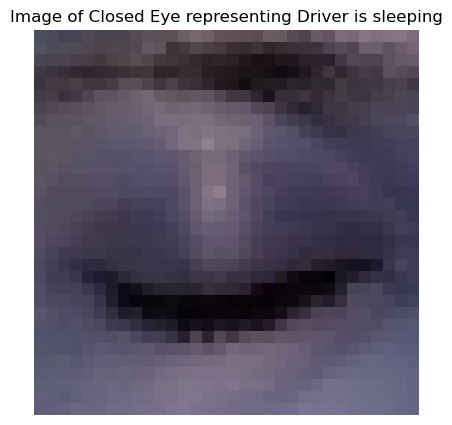

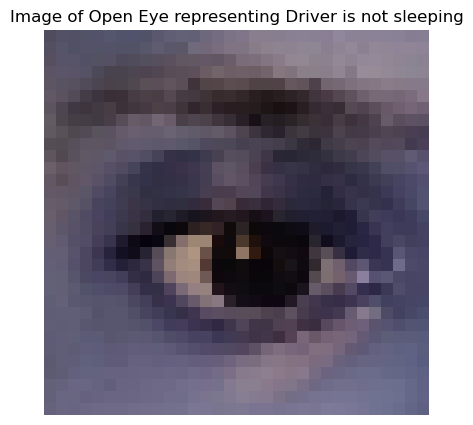

In [9]:
figure1 = plt.figure(figsize=(5, 5))
idx_closed = np.where(Y==0)
img_closed = X[idx_closed[0][0]]
plt.imshow(img_closed)
plt.title('Image of Closed Eye representing Driver is sleeping')
plt.axis('off')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
idx_open = np.where(Y==1)
img_open = X[idx_open[0][0]]
plt.imshow(img_open)
plt.title('Image of Open Eye representing Driver is not sleeping')
plt.axis('off')
plt.show()

# Visualizing the Data Distribution in Train and Test Set

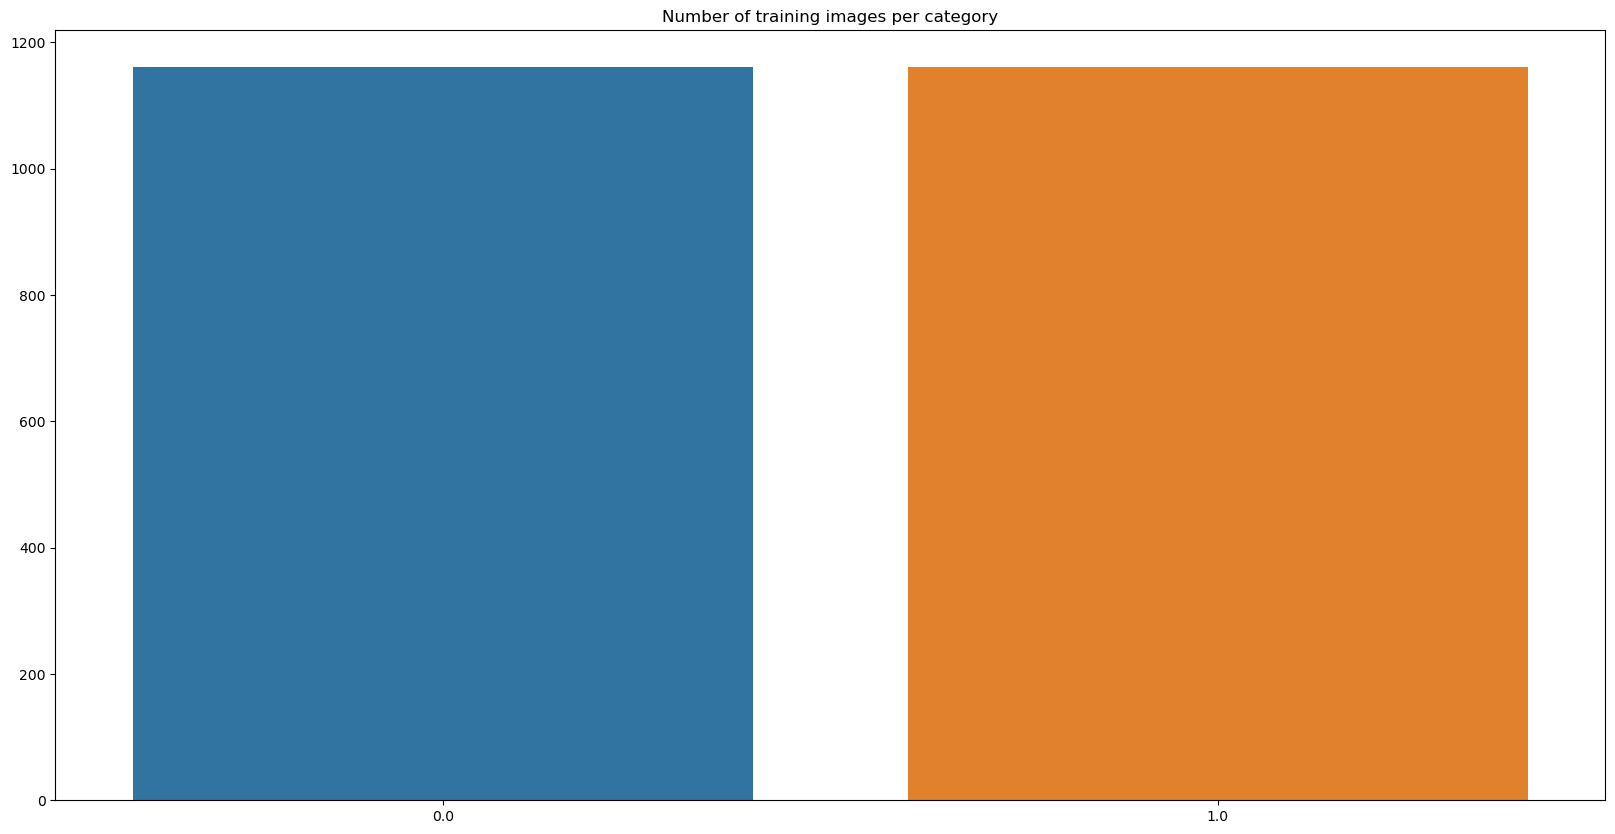

In [10]:
# Assuming you have already defined Y_train
unique_train, count = np.unique(Y_train, return_counts=True)

plt.figure(figsize=(20, 10))
sns.barplot(x=unique_train, y=count)
plt.title("Number of training images per category")
plt.show()


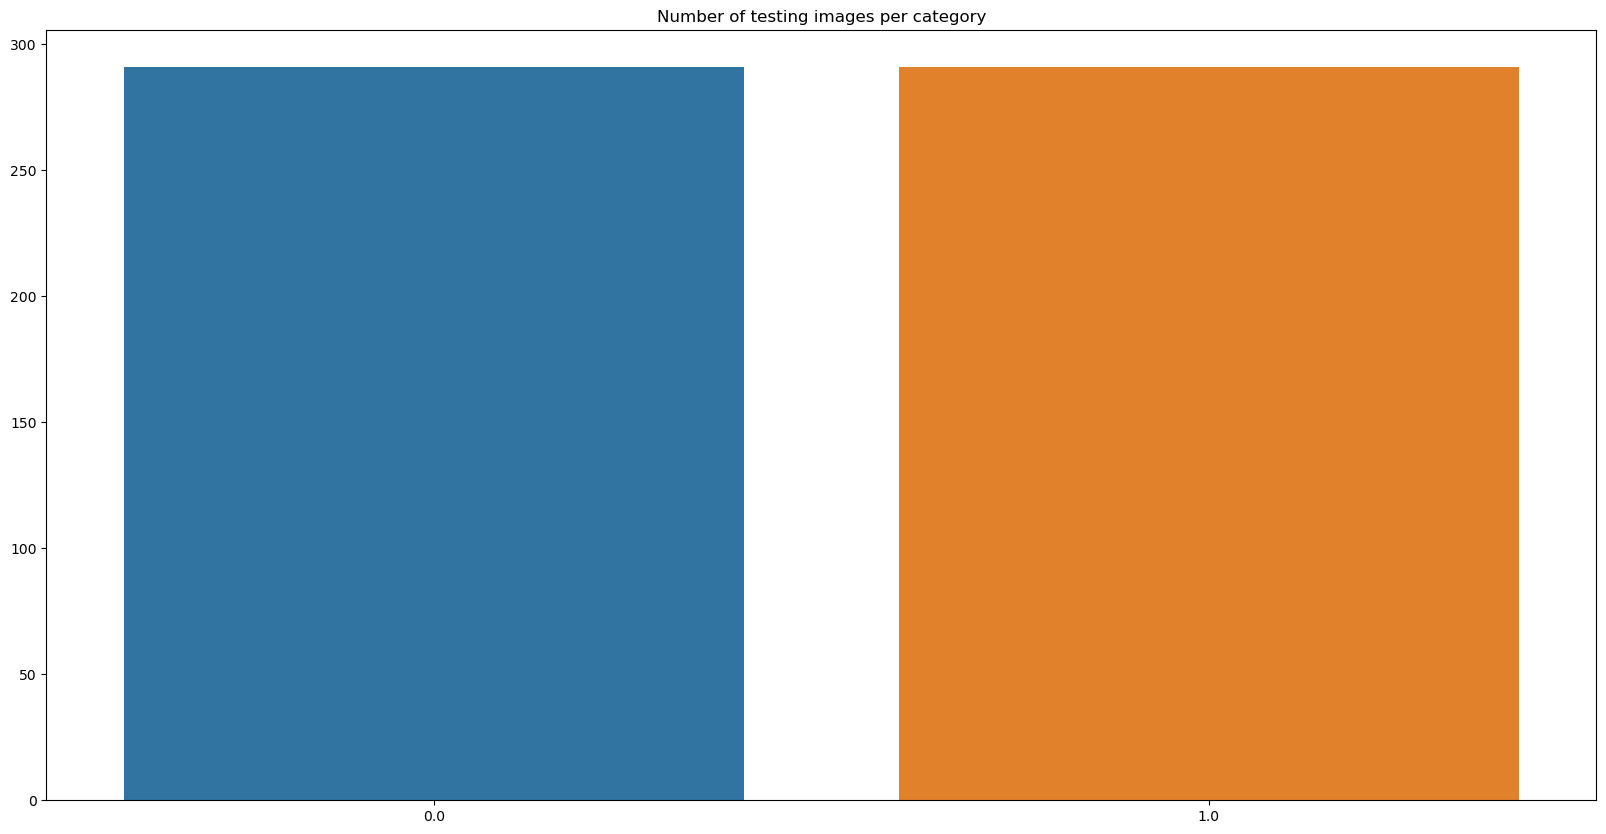

In [11]:
# Assuming you have already defined Y_test
unique_test, count_test = np.unique(Y_test, return_counts=True)

plt.figure(figsize=(20, 10))
sns.barplot(x=unique_test, y=count_test)
plt.title("Number of testing images per category")
plt.show()

# Defining the Model Architecture

In [12]:
def driver_drowsiness_detection_model(input_shape=(32, 32, 3)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv1', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv2', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv5', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv6', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv7', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam(0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
model= driver_drowsiness_detection_model(input_shape=(32, 32, 3))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)       

# Training the Model
#### Learning Rate - 0.0001
#### Optimizer - Adam
#### Number of Epochs - 200
#### Batch Size = 128

In [14]:
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.2,
                         horizontal_flip=True)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128),
                 batch_size=128,
                 epochs=200, 
                 validation_data=(X_test, Y_test))

Epoch 1/200


10/10 [==============================] - 11s 522ms/step - loss: 1.2988 - accuracy: 0.5245 - val_loss: 0.7265 - val_accuracy: 0.4536
Epoch 2/200
10/10 [==============================] - 4s 355ms/step - loss: 1.1121 - accuracy: 0.5547 - val_loss: 0.7068 - val_accuracy: 0.4708
Epoch 3/200
10/10 [==============================] - 4s 385ms/step - loss: 1.0898 - accuracy: 0.5512 - val_loss: 0.6846 - val_accuracy: 0.5086
Epoch 4/200
10/10 [==============================] - 4s 406ms/step - loss: 0.9594 - accuracy: 0.5805 - val_loss: 0.6621 - val_accuracy: 0.5739
Epoch 5/200
10/10 [==============================] - 4s 361ms/step - loss: 0.9171 - accuracy: 0.5762 - val_loss: 0.6422 - val_accuracy: 0.6564
Epoch 6/200
10/10 [==============================] - 4s 367ms/step - loss: 0.8307 - accuracy: 0.6158 - val_loss: 0.6334 - val_accuracy: 0.7423
Epoch 7/200
10/10 [==============================] - 5s 450ms/step - loss: 0.8008 - accuracy: 0.6038 - val_loss: 0.6250 - val_accuracy: 0.7

Epoch 55/200
10/10 [==============================] - 4s 390ms/step - loss: 0.2246 - accuracy: 0.9130 - val_loss: 0.1349 - val_accuracy: 0.9450
Epoch 56/200
10/10 [==============================] - 4s 398ms/step - loss: 0.2327 - accuracy: 0.9070 - val_loss: 0.1336 - val_accuracy: 0.9450
Epoch 57/200
10/10 [==============================] - 4s 370ms/step - loss: 0.1972 - accuracy: 0.9199 - val_loss: 0.1348 - val_accuracy: 0.9519
Epoch 58/200
10/10 [==============================] - 4s 351ms/step - loss: 0.2139 - accuracy: 0.9121 - val_loss: 0.1357 - val_accuracy: 0.9485
Epoch 59/200
10/10 [==============================] - 4s 400ms/step - loss: 0.2077 - accuracy: 0.9233 - val_loss: 0.1273 - val_accuracy: 0.9485
Epoch 60/200
10/10 [==============================] - 4s 362ms/step - loss: 0.1982 - accuracy: 0.9182 - val_loss: 0.1205 - val_accuracy: 0.9450
Epoch 61/200
10/10 [==============================] - 4s 377ms/step - loss: 0.1785 - accuracy: 0.9354 - val_loss: 0.1180 - val_accuracy:

Epoch 112/200
10/10 [==============================] - 4s 370ms/step - loss: 0.0851 - accuracy: 0.9673 - val_loss: 0.0567 - val_accuracy: 0.9725
Epoch 113/200
10/10 [==============================] - 4s 361ms/step - loss: 0.0837 - accuracy: 0.9767 - val_loss: 0.0534 - val_accuracy: 0.9656
Epoch 114/200
10/10 [==============================] - 4s 364ms/step - loss: 0.0722 - accuracy: 0.9673 - val_loss: 0.0514 - val_accuracy: 0.9691
Epoch 115/200
10/10 [==============================] - 4s 366ms/step - loss: 0.0778 - accuracy: 0.9690 - val_loss: 0.0513 - val_accuracy: 0.9725
Epoch 116/200
10/10 [==============================] - 4s 365ms/step - loss: 0.0616 - accuracy: 0.9733 - val_loss: 0.0650 - val_accuracy: 0.9725
Epoch 117/200
10/10 [==============================] - 4s 348ms/step - loss: 0.0816 - accuracy: 0.9716 - val_loss: 0.0627 - val_accuracy: 0.9691
Epoch 118/200
10/10 [==============================] - 4s 357ms/step - loss: 0.0598 - accuracy: 0.9802 - val_loss: 0.0575 - val_ac

10/10 [==============================] - 4s 369ms/step - loss: 0.0412 - accuracy: 0.9828 - val_loss: 0.0406 - val_accuracy: 0.9828
Epoch 169/200
10/10 [==============================] - 4s 436ms/step - loss: 0.0408 - accuracy: 0.9836 - val_loss: 0.0462 - val_accuracy: 0.9828
Epoch 170/200
10/10 [==============================] - 4s 421ms/step - loss: 0.0400 - accuracy: 0.9845 - val_loss: 0.0389 - val_accuracy: 0.9897
Epoch 171/200
10/10 [==============================] - 4s 359ms/step - loss: 0.0635 - accuracy: 0.9802 - val_loss: 0.0355 - val_accuracy: 0.9897
Epoch 172/200
10/10 [==============================] - 4s 367ms/step - loss: 0.0483 - accuracy: 0.9802 - val_loss: 0.0377 - val_accuracy: 0.9897
Epoch 173/200
10/10 [==============================] - 4s 364ms/step - loss: 0.0336 - accuracy: 0.9922 - val_loss: 0.0477 - val_accuracy: 0.9828
Epoch 174/200
10/10 [==============================] - 4s 375ms/step - loss: 0.0431 - accuracy: 0.9819 - val_loss: 0.0548 - val_accuracy: 0.9828

# Plotting Loss Values and Accuracy against Number of Epochs for Train Set and Test Set

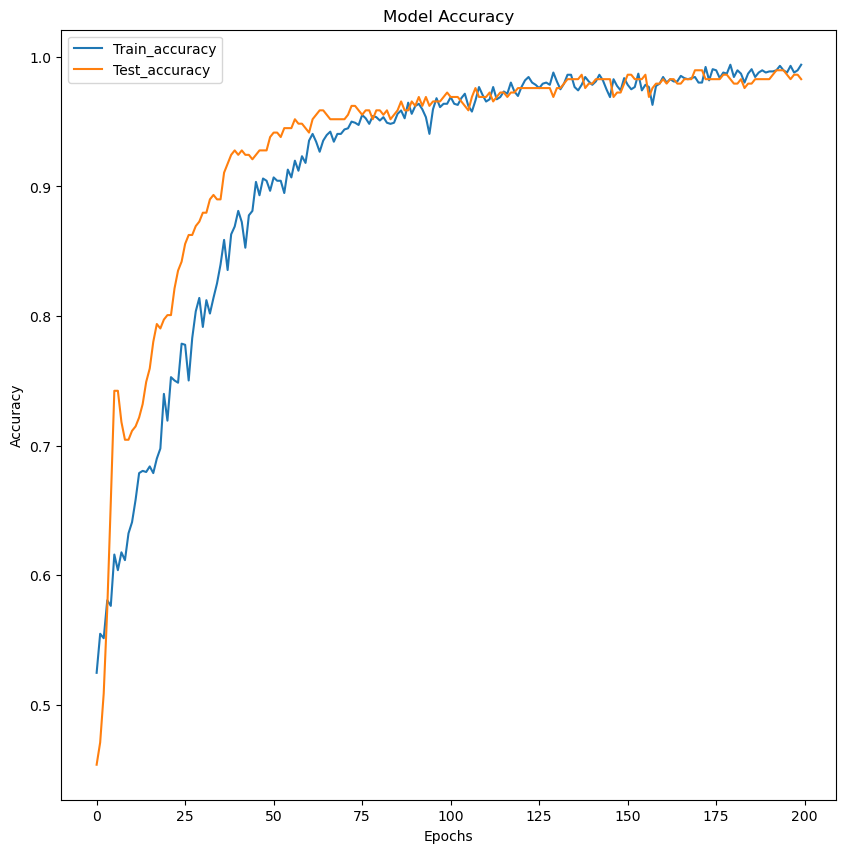

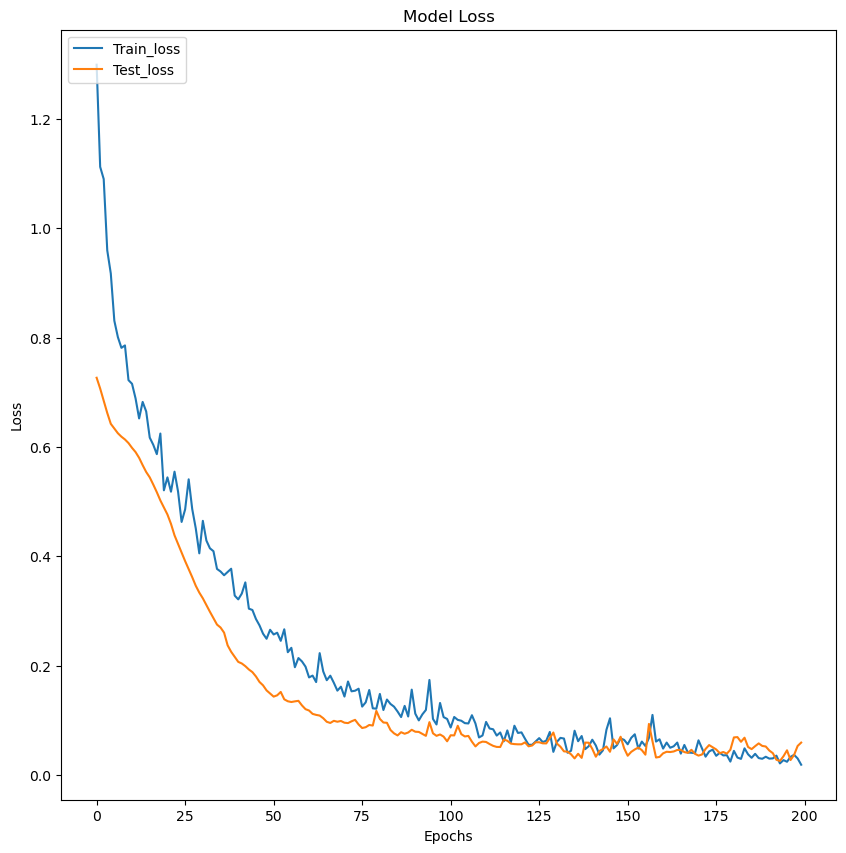

In [15]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train_accuracy')
plt.plot(hist.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train_loss')
plt.plot(hist.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

# Evaluating Model on Test Set

In [16]:
pred = model.evaluate(X_test, Y_test)
print(f'Test Set Accuracy: {pred[1]}')
print(f'Test Set Loss: {pred[0]}')

10/10 [==============================] - 0s 27ms/step - loss: 0.0594 - accuracy: 0.9828
Test Set Accuracy: 0.9828178882598877
Test Set Loss: 0.05935543030500412


# Classification Report

In [17]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_pred = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_pred, ypred))

10/10 [==============================] - 1s 26ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       159
           1       0.96      1.00      0.98       132

    accuracy                           0.98       291
   macro avg       0.98      0.98      0.98       291
weighted avg       0.98      0.98      0.98       291



# Confusion Matrix

<Axes: >

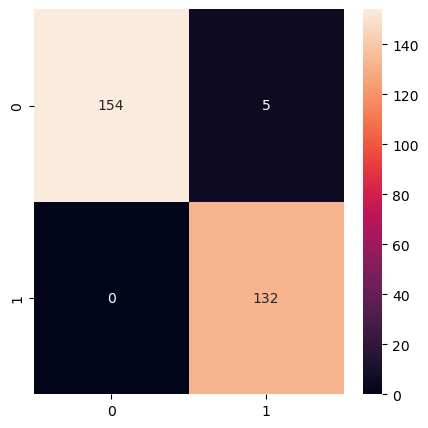

In [18]:
matrix = confusion_matrix(Y_test_pred, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1], columns=[0, 1])
figure = plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, fmt='d')

# Saving the Model

In [19]:
model.save('Driver_Drowsiness_Detection.h5')

C:\Users\Bhargavi\anaconda3\PVB\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Testing Model on Images

## Testing the classification performnace on random images of Open and Closed Eyes

In [20]:
labels = ['Closed', 'Open']
img_closed1 = cv2.imread('driver_drowsiness_detection/closed_eye.jpg')
img_closed2 = cv2.imread('driver_drowsiness_detection/closed_eye2.jpg')
img_open1 = cv2.imread('driver_drowsiness_detection/open_eye.jpg')
img_open2 = cv2.imread('driver_drowsiness_detection/open_eye2.jpg')

img_closed1 = cv2.resize(img_closed1, (32, 32))
img_closed2 = cv2.resize(img_closed2, (32, 32))
img_open1 = cv2.resize(img_open1, (32, 32))
img_open2 = cv2.resize(img_open2, (32, 32))

img_closed1 = np.array(img_closed1)
img_closed2 = np.array(img_closed2)
img_open1 = np.array(img_open1)
img_open2 = np.array(img_open2)

img_closed1 = np.expand_dims(img_closed1, axis=0)
img_closed2 = np.expand_dims(img_closed2, axis=0)
img_open1 = np.expand_dims(img_open1, axis=0)
img_open2 = np.expand_dims(img_open2, axis=0)

In [21]:
ypred_closed1 = model.predict(img_closed1)
ypred_closed2 = model.predict(img_closed2)
ypred_open1 = model.predict(img_open1)
ypred_open2 = model.predict(img_open2)

1/1 [==============================] - 0s 56ms/step


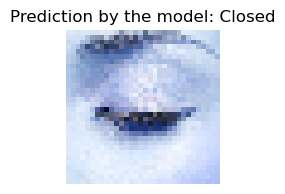

In [22]:
figure = plt.figure(figsize=(2, 2))
img_closed1 = np.squeeze(img_closed1, axis=0)
plt.imshow(img_closed1)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_closed1[0], axis=0)]}')
plt.show()

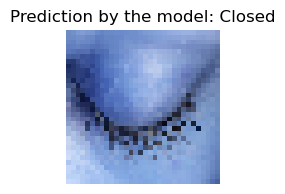

In [23]:
figure = plt.figure(figsize=(2, 2))
img_closed2 = np.squeeze(img_closed2, axis=0)
plt.imshow(img_closed2)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_closed2[0], axis=0)]}')
plt.show()

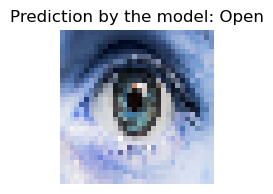

In [24]:
figure = plt.figure(figsize=(2, 2))
img_open1 = np.squeeze(img_open1, axis=0)
plt.imshow(img_open1)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_open1[0], axis=0)]}')
plt.show()

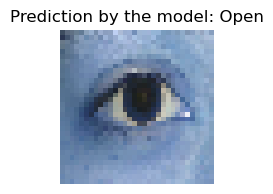

In [25]:
figure = plt.figure(figsize=(2, 2))
img_open2 = np.squeeze(img_open2, axis=0)
plt.imshow(img_open2)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_open2[0], axis=0)]}')
plt.show()

# Creating Pipeline for making predictions on full face images

In [26]:
def full_face_detection_pipeline(input_image_path):
    face_cascade = cv2.CascadeClassifier('driver_drowsiness_detection/haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier('driver_drowsiness_detection/haarcascade_eye.xml')
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('driver_drowsiness_detection/shape_predictor_68_face_landmarks.dat')
    fa = FaceAligner(predictor, desiredFaceWidth=256)
    test_image = cv2.imread(input_image_path)
    test_image = imutils.resize(test_image, width=800)
    test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    rects = detector(test_image_gray, 2)
    for rect in rects:
        (x, y, w, h) = rect_to_bb(rect)
        faceOrig = imutils.resize(test_image[y:y+h, x:x+w], width=256)
        faceAligned = fa.align(test_image, test_image_gray, rect)
        faceAligned_gray = cv2.cvtColor(faceAligned, cv2.COLOR_BGR2GRAY)
        plt.imshow(faceAligned_gray)
        plt.axis('off')
        plt.title('Aligned Face')
        plt.show()
        eyes = eye_cascade.detectMultiScale(faceAligned_gray, 1.1, 4)
        predictions = []
        for (ex, ey, ew, eh) in eyes:
            eye = faceAligned[ey:ey+eh, ex:ex+ew]
#             cv2.rectangle(test_image, (x+ex, y+ey), (x+ex+ew, y+ey+eh), (0, 0, 255), 8)
            eye = cv2.resize(eye, (32, 32))
            eye = np.array(eye)
            eye = np.expand_dims(eye, axis=0)
            ypred = model.predict(eye)
            ypred = np.argmax(ypred[0], axis=0)
            predictions.append(ypred)
        if all(i==0 for i in predictions):
            cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 0, 255), 8)
            cv2.putText(test_image, 'Sleeping', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
        else:
            cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 255, 0), 8)
            cv2.putText(test_image, 'Not Sleeping', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)
    output_path = 'driver_drowsiness_detection/test_image_prediction.jpg'
    cv2.imwrite(output_path, test_image) 
    return output_path

In [ ]:
import cv2

# Load the input image
input_image_path = 'driver_drowsiness_detection/drowsy_person.jpg'
input_image = cv2.imread(input_image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

# Load the pre-trained Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Perform face detection
faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Draw rectangles around the detected faces
for (x, y, w, h) in faces:
    cv2.rectangle(input_image, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Display the image with detected faces
cv2.imshow('Detected Faces', input_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [41]:
# Load the input image
input_image_path = 'driver_drowsiness_detection/sleepy-driver.jpg'
input_image = cv2.imread(input_image_path)

    # Convert the image to grayscale
gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

    # Load the pre-trained Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Perform face detection
faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Draw rectangles around the detected faces
for (x, y, w, h) in faces:
    cv2.rectangle(input_image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Display the image with detected faces
cv2.imshow('Detected Faces', input_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [42]:
# Load the input image
input_image_path = 'driver_drowsiness_detection/active_person.jpg'
input_image = cv2.imread(input_image_path)

    # Convert the image to grayscale
gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

    # Load the pre-trained Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Perform face detection
faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Draw rectangles around the detected faces
for (x, y, w, h) in faces:
    cv2.rectangle(input_image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Display the image with detected faces
cv2.imshow('Detected Faces', input_image)
cv2.waitKey(0)
cv2.destroyAllWindows()